In [98]:
#import useful libraries
import os
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401 unused import
import pickle
import configuration
import general_statistics as stats
import figures as figs
import matplotlib.cm as cm
from matplotlib import colors
from scipy import signal
from scipy import stats as sstats
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import scipy
cmap = cm.jet
import math
from sklearn.datasets import load_iris
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import confusion_matrix
from sklearn.cross_decomposition import CCA
from sklearn.model_selection import cross_val_score
import random
from sklearn.cluster import KMeans
from sklearn.metrics.cluster import adjusted_mutual_info_score
from sklearn.metrics import mutual_info_score
from sklearn.pipeline import Pipeline
from sklearn.model_selection import KFold


In [104]:
# define mouse information, and preprocessin versions from analysis.
# load data for all sessions in this mouse and compute mean activity for each neuron.

mouse = 56165       ### mouse number id
decoding_v = 1            ## decoding version, normaly equal to one
motion_correction_v = 20  ### 100 means everything was aligned, 200 means it was also equalized, 20 is for day wise
alignment_v = 3           ## alignment version, version 3 is for day wise
equalization_v = 0        ## equalization version
source_extraction_v = 1   ## source extraction version
component_evaluation_v = 1 ## component evaluation version

# here we will do analysis with no registration
# registration_v = 2        ## registration version
sf = 10                   ## sampling frequency of the original signal 
re_sf=1            ## value of resampling
session_now = 1
BINS = 70
FR_limit = 10
period = int(1 * sf / re_sf)
period_resting = period *10
fixed = 'None'
## define task for plotting. This will cahnge for other mice!!!!

if mouse == 56165 or mouse == 32364:
    if mouse == 56165:
        sessions = [1,2,4]       ## sessions for this particular mouse
    if mouse == 32364:
        sessions = [1,2]
    if session_now == 1:
        task = 'OVERLAPPING'
        colapse_behaviour = 1
        labels =['Unlabel','Rest1', 'Navigation', 'Obj1' , 'Obj2', 'Run1', 'Run2']
        colornames=['k',"r","deepskyblue","g","blue","g","blue"]
        if mouse == 32364:
            fixed = 'LR'
            object_fixed = 4
            colapse_behaviour = 1
            labels =['Unlabel','Rest1', 'Navigation', 'Overlap_object' , 'Moving_object','RunOO' , 'RunMO' ]
            colornames=['k',"r","deepskyblue","g","blue","g","blue"]   
        if mouse == 56165:
            fixed = 'UR'
            object_fixed = 5
            colapse_behaviour = 1
            labels =['Unlabel','Rest1', 'Navigation', 'Overlap_object' , 'Moving_object','RunOO' , 'RunMO' ]
            colornames=['k',"r","deepskyblue","g","blue","g","blue"]   

    else:
        if session_now == 2:
            task = 'STABLE'
            colapse_behaviour = 2
            labels =['Unlabel','Rest1', 'Navigation', 'Obj1' , 'Obj2', 'Run1', 'Run2']
            colornames=['k',"r","deepskyblue","g","blue","g","blue"]
        else:
            task = 'RANDOM'
            colapse_behaviour = 0
            labels =['Unlabel','Rest1', 'Navigation', 'Obj1' , 'Obj2', 'Run1', 'Run2']
            colornames=['k',"r","deepskyblue","g","blue","g","blue"]
            
if mouse == 32365:
    sessions = [2,3] ## sessions for this particular mouse
    if session_now == 2:
        task = 'RANDOM'
        colapse_behaviour = 0
        labels =['Unlabel','Rest1', 'Navigation', 'Obj1' , 'Obj2', 'Run1', 'Run2']
        colornames=['k',"r","deepskyblue","g","blue","g","blue"]
    else:
        if session_now == 3:
            task = 'OVERLAPPING'
            fixed = 'LR'
            object_fixed = 4
            colapse_behaviour = 1
            labels =['Unlabel','Rest1', 'Navigation', 'Overlap_object' , 'Moving_object','RunOO' , 'RunMO' ]
            colornames=['k',"r","deepskyblue","g","blue","g","blue"]           
            
if mouse == 56166:
    sessions = [1,2] ## sessions for this particular mouse
    if session_now == 1:
        task = 'RANDOM'
        colapse_behaviour = 0
        labels =['Unlabel','Rest1', 'Navigation', 'Obj1' , 'Obj2', 'Run1', 'Run2']
        colornames=['k',"r","deepskyblue","g","blue","g","blue"]

    else:
        if session_now == 2:
            task = 'OVERLAPPING'
            fixed = 'UR'
            object_fixed = 5
            colapse_behaviour = 1
            labels =['Unlabel','Rest1', 'Navigation', 'Overlap_object' , 'Moving_object','RunOO' , 'RunMO' ]
            colornames=['k',"r","deepskyblue","g","blue","g","blue"]
            
if mouse == 32366:
    sessions = [2,3] ## sessions for this particular mouse
    if session_now == 3:
        task = 'RANDOM'
        colapse_behaviour = 0
        labels =['Unlabel','Rest1', 'Navigation', 'Obj1' , 'Obj2', 'Run1', 'Run2']
        colornames=['k',"r","deepskyblue","g","blue","g","blue"]
            
if mouse == 32363:
    sessions = [1,2] ## sessions for this particular mouse
    if session_now == 1:
        task = 'RANDOM'
        colapse_behaviour = 0
        labels =['Unlabel','Rest1', 'Navigation', 'Obj1' , 'Obj2', 'Run1', 'Run2']
        colornames=['k',"r","deepskyblue","g","blue","g","blue"]
    else:
        if session_now == 2:
            task = 'OVERLAPPING'
            fixed = 'UL'
            object_fixed = 6
            colapse_behaviour = 1
            labels =['Unlabel','Rest1', 'Navigation', 'Overlap_object' , 'Moving_object','RunOO' , 'RunMO' ]
            colornames=['k',"r","deepskyblue","g","blue","g","blue"]

In [105]:
file_directory = os.environ['PROJECT_DIR'] + 'neural_analysis/data/calcium_activity_day_wise/'
timeline_file_dir = os.environ['PROJECT_DIR'] + 'neural_analysis/data/timeline/'
behaviour_dir = os.environ['PROJECT_DIR'] + 'calcium_imaging_behaviour/data/ethogram/' + f'{mouse}' + '/session_' + f'{session_now}' + '/'
behaviour_dir_unsup = os.environ['PROJECT_DIR'] + 'calcium_imaging_behaviour/data/ethogram_unsupervised/' + f'{mouse}' + '/session_' + f'{session_now}' + '/'
behaviour_dir_parameters = os.environ['PROJECT_DIR'] + 'calcium_imaging_behaviour/data/ethogram_parameters/' + f'{mouse}' + '/session_' + f'{session_now}' + '/'
tracking_dir = os.environ['PROJECT_DIR'] + 'calcium_imaging_behaviour/data/center_of_mass/' + f'{mouse}' + '/session_' + f'{session_now}' + '/'
objects_dir= os.environ['PROJECT_DIR'] + 'calcium_imaging_behaviour/data/object_positions/'
figure_path = os.environ['PROJECT_DIR'] +'neural_analysis/figures/'

In [106]:
    # define all relevant files names and load them into a list
    session = session_now

    activity_list = []
    timeline_list = []
    behaviour_list = []
    behaviour_list_unsup = []
    parameters_list = []
    tracking_list = []
    total_time = 0
    day = 0    
    print('LOADING TRIALS ACTIVITY AND CREATING LIST OF ACTIVITY, TRACKING AND BEHAVIOUR')
    for trial in [1,6,11,16]:

        beh_file_name_1 = 'mouse_' + f'{mouse}' + '_session_' + f'{session}' + '_day_' + f'{day+1}' + '_likelihood_0.75_ethogram.npy'
        ## LOAD BEHAVIOUR
        behaviour = np.load(behaviour_dir + beh_file_name_1)
        reshape_behaviour = np.reshape(behaviour[:int(int(behaviour.shape[0]/re_sf)*re_sf)],(int(behaviour.shape[0]/re_sf),re_sf))
        resample_beh1 = np.reshape(scipy.stats.mode(reshape_behaviour,axis=1)[0],reshape_behaviour.shape[0])

        beh_file_name_1 = 'mouse_' + f'{mouse}' + '_session_' + f'{session}' + '_day_' + f'{day+1}' + '_likelihood_0.75_parameters.npy'
        ## LOAD PARAMETRS FOR BEHAVIOUR CLASSIFICATION
        parameters = np.load(behaviour_dir_parameters + beh_file_name_1)
        params = []
        for param in range(parameters.shape[0]):
            r1_params = np.reshape(parameters[param,:int(int(behaviour.shape[0]/re_sf)*re_sf)],(int(behaviour.shape[0]/re_sf),re_sf))
            r2_params = np.reshape(scipy.stats.mode(r1_params,axis=1)[0],reshape_behaviour.shape[0])
            params.append(r2_params)
        resample_params = np.array(params)
        
        beh_file_name_1 = 'mouse_' + f'{mouse}' + '_session_' + f'{session}' + '_day_' + f'{day+1}' + '_likelihood_0.75_unsupervised_ethogram.npy'
        ## LOAD BEHAVIOUR UNSUPERVISED
        behaviour = np.load(behaviour_dir_unsup + beh_file_name_1)
        reshape_behaviour = np.reshape(behaviour[:int(int(behaviour.shape[0]/re_sf)*re_sf)],(int(behaviour.shape[0]/re_sf),re_sf))
        resample_beh1_unsup = np.reshape(scipy.stats.mode(reshape_behaviour,axis=1)[0],reshape_behaviour.shape[0])


        ## LOAD TRACKING
        tracking_file_name_1 = 'mouse_' + f'{mouse}' + '_session_' + f'{session}' + '_day_' + f'{day+1}' + '_likelihood_0.75.npy'
        position = np.load(tracking_dir + tracking_file_name_1)
        resample_position, resample_position_stc = stats.resample_matrix(neural_activity=position.T,
                                                                                            re_sf=re_sf)
        ## LOAD TIMELINE
        time_file_session_1 =  'mouse_'+ f'{mouse}'+'_session_'+ f'{session}' +'_trial_'+ f'{trial}'+'_v1.3.1.0_10.pkl'

        timeline_file= open(timeline_file_dir + time_file_session_1,'rb')
        timeline_info = pickle.load(timeline_file)
        timeline_1 = np.zeros(len(timeline_info) + 1)
        for i in range(len(timeline_info)):
            timeline_1[i] = timeline_info[i][1]
        timeline_1[len(timeline_info)] = behaviour.shape[0]
        timeline = timeline_1/re_sf
        time_lenght = 10
        resample_timeline = timeline_1/re_sf
        timeline_list.append(resample_timeline)

        behaviour_list.append(resample_beh1)
        behaviour_list_unsup.append(resample_beh1_unsup)
        parameters_list.append(resample_params)
        tracking_list.append(resample_position)
        total_time = total_time + behaviour.shape[0]


        file_name_session_1 = 'mouse_' + f'{mouse}' + '_session_' + f'{session}' + '_trial_'+ f'{trial}'+'_v' + f'{decoding_v}' + '.4.' + f'{motion_correction_v}' + \
                              '.' + f'{alignment_v}' + '.' + f'{equalization_v}' + '.' + f'{source_extraction_v}' + '.' + \
                              f'{component_evaluation_v}' +  '.0.npy'

        ##load activity and timeline
        activity = np.load(file_directory + file_name_session_1)
        neural_activity1 = activity[1:,:]
        ## z-score neural activity
        neural_activity = neural_activity1
        ##downsample neural activity
        resample_neural_activity_mean, resample_neural_activity_std = stats.resample_matrix(neural_activity=neural_activity,
                                                                                            re_sf=re_sf)

        activity_list.append(resample_neural_activity_mean)

        day = day + 1
        
        ## define targets of behaviour according to protocol (random, overlapping and stable)

LOADING TRIALS ACTIVITY AND CREATING LIST OF ACTIVITY, TRACKING AND BEHAVIOUR


In [107]:
    id_target = [0,1,2,3,4,5,6] # 0: unlabeled, 1:resting, 2:Navigation, 3: Obj1, 4:Obj2, 5:Run1, 6:Run2
    
    print('REDIFINING BEHAVIOUR FOR DIFFERENT SESSIONS')

    if colapse_behaviour == 0 : # RANDOM
        for day in range(len(behaviour_list)):
            for trial in range(5):
                behaviour_trial = behaviour_list[day][int(timeline_list[day][2*trial]):int(timeline_list[day][2*trial+1])]
                objects = np.unique(behaviour_trial)
                selected_object = np.random.randint(len(objects)-4,len(objects)-2,1)
                index0 = np.where(behaviour_trial==objects[selected_object])[0]
                index1 = np.where(np.logical_and(behaviour_trial==objects[len(objects)-4], behaviour_trial!=objects[selected_object]))
                index2 = np.where(np.logical_and(behaviour_trial==objects[len(objects)-3], behaviour_trial!=objects[selected_object]))
                behaviour_trial[index0] = 3
                behaviour_trial[index1] = 4
                behaviour_trial[index2] = 4            

                index0 = np.where(behaviour_trial==objects[selected_object]+4)[0]
                index1 = np.where(np.logical_and(behaviour_trial==objects[len(objects)-2], behaviour_trial!=objects[selected_object]+4))
                index2 = np.where(np.logical_and(behaviour_trial==objects[len(objects)-1], behaviour_trial!=objects[selected_object]+4))
                behaviour_trial[index0] = 5
                behaviour_trial[index1] = 6
                behaviour_trial[index2] = 6 

                behaviour_list[day][int(timeline_list[day][2*trial]):int(timeline_list[day][2*trial+1])] = behaviour_trial


    if colapse_behaviour == 1 : #OVERLAPPING
        for day in range(len(behaviour_list)):
            behaviour_list[day][np.where(behaviour_list[day] == object_fixed)[0]] = 100
            behaviour_list[day][np.where(np.logical_and(behaviour_list[day]>=3, behaviour_list[day]<=6))[0]] = 4
            behaviour_list[day][np.where(behaviour_list[day] == 100)[0]] = 3        
            behaviour_list[day][np.where(behaviour_list[day] == object_fixed +4)[0]] = 200        
            behaviour_list[day][np.where(np.logical_and(behaviour_list[day]>=7, behaviour_list[day]<=10))[0]] = 6
            behaviour_list[day][np.where(behaviour_list[day] == 200)[0]] = 5        


    if colapse_behaviour == 2: #STABLE
        for day in range(len(behaviour_list)):
            objects = np.unique(behaviour_list[day])
            selected_object = np.random.randint(len(objects)-4,len(objects)-2,1)
            index0 = np.where(behaviour_list[day]==objects[selected_object])[0]
            index1 = np.where(np.logical_and(behaviour_list[day]==objects[len(objects)-4], behaviour_list[day]!=objects[selected_object]))
            index2 = np.where(np.logical_and(behaviour_list[day]==objects[len(objects)-3], behaviour_list[day]!=objects[selected_object]))
            behaviour_list[day][index0] = 3
            behaviour_list[day][index1] = 4
            behaviour_list[day][index2] = 4      

            index0 = np.where(behaviour_list[day]==objects[selected_object]+4)[0]
            index1 = np.where(np.logical_and(behaviour_list[day]==objects[len(objects)-2], behaviour_list[day]!=objects[selected_object]+4))
            index2 = np.where(np.logical_and(behaviour_list[day]==objects[len(objects)-1], behaviour_list[day]!=objects[selected_object]+4))
            behaviour_list[day][index0] = 5
            behaviour_list[day][index1] = 6
            behaviour_list[day][index2] = 6  

REDIFINING BEHAVIOUR FOR DIFFERENT SESSIONS


In [111]:
performance_data = np.zeros((20,))
performance_data_std = np.zeros((20,))
performance_cca = np.zeros((20,))
performance_cca_std = np.zeros((20,))

performance_data_unsup = np.zeros((20,))
performance_data_std_unsup = np.zeros((20,))
performance_cca_unsup = np.zeros((20,))
performance_cca_std_unsup = np.zeros((20,))

performance_data_shuffle = np.zeros((20,))
performance_data_std_shuffle = np.zeros((20,))
performance_cca_shuffle = np.zeros((20,))
performance_cca_std_shuffle = np.zeros((20,))

performance_data_unsup_shuffle = np.zeros((20,))
performance_data_std_unsup_shuffle = np.zeros((20,))
performance_cca_unsup_shuffle = np.zeros((20,))
performance_cca_std_unsup_shuffle = np.zeros((20,))

for day in [0,1,2,3]:
    
    for trial in range(5):
        time0 = int(timeline_list[day][trial*2])
        time1 = int(timeline_list[day][trial*2+1])

        tracking_trial = tracking_list[day][:,time0:time1]
        behaviour_trial = behaviour_list[day][time0:time1]
        behaviour_trial_unsup = behaviour_list_unsup[day][time0:time1]
        parameters_trial = parameters_list[day][:,time0:time1]
        index_track = np.where(behaviour_trial_unsup>0)[0]

        ybehaviour= behaviour_trial[index_track]
        ybehaviour_unsup = behaviour_trial_unsup[index_track]
        yparameters = parameters_trial[:,index_track]

        ### prepare neural data
        Xpre = activity_list[day][:,time0:time1].T
        Xpre = Xpre[index_track,:]
        
        firing_rate = np.mean(Xpre,axis = 0)*10
        selected_cells = np.where(firing_rate < FR_limit)[0]
        Xpre = Xpre[:,selected_cells]
        
        ### solve class inbalance by taking the minimun occupancy lengh supervised
#         min_exploration = Xpre.shape[0]
#         for i in range(1,7):
#             exploration = np.where(ybehaviour == i)[0].shape[0]
#             if exploration < min_exploration and exploration!=0: min_exploration = exploration 
        
#         selected_temporal_bins = []
#         for i in range(1,7):
#             exploration = list(np.where(ybehaviour == i)[0])
#             selection = random.sample(exploration, min_exploration)
#             selected_temporal_bins = selected_temporal_bins + selection
            
        selected_temporal_bins = np.arange(0,Xpre.shape[0])
        X = Xpre[selected_temporal_bins,:]
        Xshuffle = X.copy()
        np.random.shuffle(Xshuffle)
        ybehaviour = ybehaviour[selected_temporal_bins]
        yparameters = yparameters[:,selected_temporal_bins]
 
        ## decoing in all data
        gnb = GaussianNB()
        scores = cross_val_score(gnb, X, ybehaviour, cv=10)
        performance_data[day*5+trial] =  np.mean(scores)
        performance_data_std[day*5+trial] =  np.std(scores)
        
        scores = cross_val_score(gnb, Xshuffle, ybehaviour, cv=10)
        performance_data_shuffle[day*5+trial] =  np.mean(scores)
        performance_data_std_shuffle[day*5+trial] =  np.std(scores)
        
        # do cca and decode
        cca = CCA(n_components=min(13,X.shape[1]))
        kf = KFold(n_splits=10)
        kfoldit= 0
        scores = np.zeros((10,))
        for train_index, test_index in kf.split(X):
            X_train_cca, X_test_cca = X[train_index], X[test_index]
            y_train_cca, y_test_cca = yparameters.T[train_index], yparameters.T[test_index]
            y_train_gnb, y_test_gnb = ybehaviour[train_index], ybehaviour[test_index]
            
            X_cca_train = cca.fit(X_train_cca, y_train_cca).transform(X_train_cca)
            X_cca_test = cca.fit(X_train_cca, y_train_cca).transform(X_test_cca)
            y_pred = gnb.fit(X_cca_train, y_train_gnb).predict(X_cca_test)

            scores[kfoldit] = gnb.fit(X_cca_train, y_train_gnb).score(X_cca_test, y_test_gnb)
            kfoldit = kfoldit+1
        performance_cca[day*5+trial] =  np.mean(scores)
        performance_cca_std[day*5+trial] =  np.std(scores)
        
        scores = np.zeros((10,))
        kfoldit= 0
        for train_index, test_index in kf.split(X):
            X_train_cca, X_test_cca = Xshuffle[train_index], Xshuffle[test_index]
            y_train_cca, y_test_cca = yparameters.T[train_index], yparameters.T[test_index]
            y_train_gnb, y_test_gnb = ybehaviour[train_index], ybehaviour[test_index]
            
            X_cca_train = cca.fit(X_train_cca, y_train_cca).transform(X_train_cca)
            X_cca_test = cca.fit(X_train_cca, y_train_cca).transform(X_test_cca)
            y_pred = gnb.fit(X_cca_train, y_train_gnb).predict(X_cca_test)

            scores[kfoldit] = gnb.fit(X_cca_train, y_train_gnb).score(X_cca_test, y_test_gnb)
            kfoldit = kfoldit+1
            
        #X_cca = cca.fit(Xshuffle, yparameters.T).transform(X)
        #scores = cross_val_score(gnb, X_cca, ybehaviour, cv=10)
        performance_cca_shuffle[day*5+trial] =  np.mean(scores)
        performance_cca_std_shuffle[day*5+trial] =  np.std(scores)
        
        ### UNSUPERVISED
        ### solve class inbalance by taking the minimun occupancy lengh unsupervised
#         min_exploration_unsup = Xpre.shape[0]
#         for i in range(1,7):
#             exploration = np.where(ybehaviour_unsup == i)[0].shape[0]
#             if exploration < min_exploration_unsup and exploration!=0: min_exploration_unsup = exploration 
        
#         selected_temporal_bins = []
#         for i in range(1,7):
#             exploration = list(np.where(ybehaviour_unsup == i)[0])
#             selection = random.sample(exploration, min_exploration_unsup)
#             selected_temporal_bins = selected_temporal_bins + selection
            
        selected_temporal_bins = np.arange(0,Xpre.shape[0])
        X = Xpre[selected_temporal_bins,:]
        ybehaviour_unsup = ybehaviour_unsup[selected_temporal_bins]
        yparameters_unsup = parameters_list[day][:,selected_temporal_bins]
        
        ## decoing in all data
        gnb = GaussianNB()
        scores = cross_val_score(gnb, X, ybehaviour_unsup, cv=10)
        performance_data_unsup[day*5+trial] =  np.mean(scores)
        performance_data_std_unsup[day*5+trial] =  np.std(scores)
        
        scores = cross_val_score(gnb, Xshuffle, ybehaviour_unsup, cv=10)
        performance_data_unsup_shuffle[day*5+trial] =  np.mean(scores)
        performance_data_std_unsup_shuffle[day*5+trial] =  np.std(scores)
        
        # do cca and decode
#         cca = CCA(n_components=min(13,X.shape[1]))
#         X_cca = cca.fit(X, yparameters.T).transform(X)
#         scores = cross_val_score(gnb, X_cca, ybehaviour_unsup, cv=10)
#         performance_cca_unsup[day*5+trial] =  np.mean(scores)
#         performance_cca_std_unsup[day*5+trial] =  np.std(scores)

#         cca = CCA(n_components=min(13,X.shape[1]))
#         X_cca = cca.fit(Xshuffle, yparameters.T).transform(X)
#         scores = cross_val_score(gnb, X_cca, ybehaviour_unsup, cv=10)
#         performance_cca_unsup_shuffle[day*5+trial] =  np.mean(scores)
#         performance_cca_std_unsup_shuffle[day*5+trial] =  np.std(scores)


        kfoldit= 0
        scores = np.zeros((10,))
        for train_index, test_index in kf.split(X):
            X_train_cca, X_test_cca = X[train_index], X[test_index]
            y_train_cca, y_test_cca = yparameters_unsup.T[train_index], yparameters_unsup.T[test_index]
            y_train_gnb, y_test_gnb = ybehaviour_unsup[train_index], ybehaviour_unsup[test_index]
            
            X_cca_train = cca.fit(X_train_cca, y_train_cca).transform(X_train_cca)
            X_cca_test = cca.fit(X_train_cca, y_train_cca).transform(X_test_cca)
            y_pred = gnb.fit(X_cca_train, y_train_gnb).predict(X_cca_test)

            scores[kfoldit] = gnb.fit(X_cca_train, y_train_gnb).score(X_cca_test, y_test_gnb)
            kfoldit = kfoldit+1
            
        performance_cca[day*5+trial] =  np.mean(scores)
        performance_cca_std[day*5+trial] =  np.std(scores)
        
        scores = np.zeros((10,))
        kfoldit= 0
        for train_index, test_index in kf.split(X):
            X_train_cca, X_test_cca = Xshuffle[train_index], Xshuffle[test_index]
            y_train_cca, y_test_cca = yparameters_unsup.T[train_index], yparameters_unsup.T[test_index]
            y_train_gnb, y_test_gnb = ybehaviour_unsup[train_index], ybehaviour_unsup[test_index]
            
            X_cca_train = cca.fit(X_train_cca, y_train_cca).transform(X_train_cca)
            X_cca_test = cca.fit(X_train_cca, y_train_cca).transform(X_test_cca)
            y_pred = gnb.fit(X_cca_train, y_train_gnb).predict(X_cca_test)

            scores[kfoldit] = gnb.fit(X_cca_train, y_train_gnb).score(X_cca_test, y_test_gnb)
            kfoldit = kfoldit+1        

        

/home/melisa/anaconda3/lib/python3.7/site-packages/sklearn/cross_decomposition/pls_.py:292: UserWarning: Y residual constant at iteration 11
  warnings.warn('Y residual constant at iteration %s' % k)
/home/melisa/anaconda3/lib/python3.7/site-packages/sklearn/cross_decomposition/pls_.py:292: UserWarning: Y residual constant at iteration 11
  warnings.warn('Y residual constant at iteration %s' % k)
/home/melisa/anaconda3/lib/python3.7/site-packages/sklearn/cross_decomposition/pls_.py:292: UserWarning: Y residual constant at iteration 11
  warnings.warn('Y residual constant at iteration %s' % k)
/home/melisa/anaconda3/lib/python3.7/site-packages/sklearn/cross_decomposition/pls_.py:292: UserWarning: Y residual constant at iteration 11
  warnings.warn('Y residual constant at iteration %s' % k)
/home/melisa/anaconda3/lib/python3.7/site-packages/sklearn/cross_decomposition/pls_.py:292: UserWarning: Y residual constant at iteration 11
  warnings.warn('Y residual constant at iteration %s' % k)


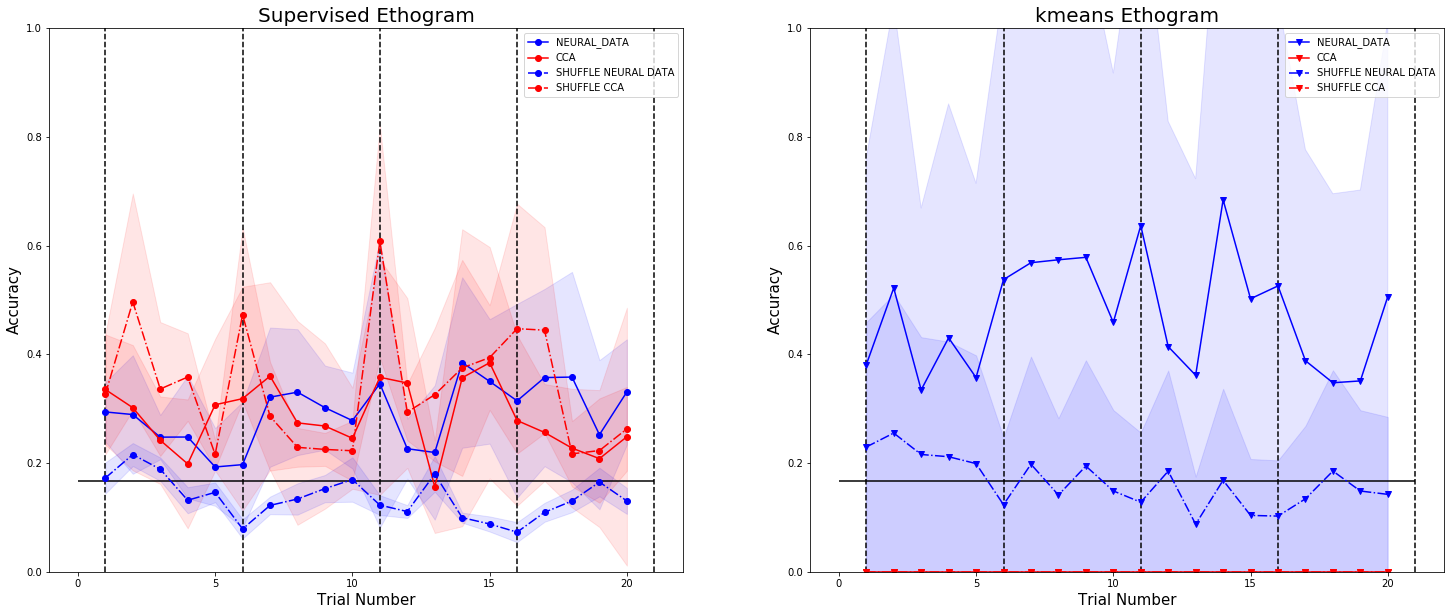

In [112]:
fig,ax = plt.subplots(1,2,figsize = (25,10))

ax[0].plot(np.arange(1,21),performance_data,color = 'b', marker='o', linestyle='-')
ax[0].fill_between(np.arange(1,21),performance_data-performance_data_std, performance_data+performance_data_std,alpha = 0.1,edgecolor='b', facecolor='b')

ax[0].plot(np.arange(1,21),performance_cca,color = 'r', marker='o', linestyle='-')
ax[0].fill_between(np.arange(1,21),performance_cca-performance_cca_std, performance_cca+performance_cca_std,alpha = 0.1,edgecolor='r', facecolor='r')

ax[0].plot(np.arange(1,21),performance_data_shuffle,color = 'b', marker='o', linestyle='-.')
ax[0].fill_between(np.arange(1,21),performance_data_shuffle-performance_data_std_shuffle, performance_data_shuffle+performance_data_std_shuffle,alpha = 0.1,edgecolor='b', facecolor='b')

ax[0].plot(np.arange(1,21),performance_cca_shuffle,color = 'r', marker='o', linestyle='-.')
ax[0].fill_between(np.arange(1,21),performance_cca_shuffle-performance_cca_std_shuffle, performance_cca_shuffle+performance_cca_std_shuffle,alpha = 0.1,edgecolor='r', facecolor='r')

ax[1].plot(np.arange(1,21),performance_data_unsup, color = 'b', marker='v', linestyle='-')
ax[1].fill_between(np.arange(1,21),performance_data_unsup-performance_data_unsup, performance_data_unsup+performance_data_unsup,alpha = 0.1,edgecolor='b', facecolor='b')

ax[1].plot(np.arange(1,21),performance_cca_unsup, color = 'r', marker='v', linestyle='-')
ax[1].fill_between(np.arange(1,21),performance_cca_unsup-performance_cca_unsup, performance_cca_unsup+performance_cca_unsup,alpha = 0.1,edgecolor='r', facecolor='r')
    
ax[1].plot(np.arange(1,21),performance_data_unsup_shuffle, color = 'b', marker='v', linestyle='-.')
ax[1].fill_between(np.arange(1,21),performance_data_unsup_shuffle-performance_data_unsup_shuffle, performance_data_unsup_shuffle+performance_data_unsup_shuffle,alpha = 0.1,edgecolor='b', facecolor='b')

ax[1].plot(np.arange(1,21),performance_cca_unsup_shuffle, color = 'r', marker='v', linestyle='-.')
ax[1].fill_between(np.arange(1,21),performance_cca_unsup_shuffle-performance_cca_unsup_shuffle, performance_cca_unsup_shuffle+performance_cca_unsup_shuffle,alpha = 0.1,edgecolor='r', facecolor='r')
     
    
ax[0].set_title('Supervised Ethogram', fontsize = 20)
ax[1].set_title('kmeans Ethogram',fontsize = 20)


for i in range(2):
    ax[i].set_ylabel('Accuracy',fontsize = 15)
    ax[i].set_xlabel('Trial Number',fontsize = 15)
    ax[i].set_ylim([0,1])
    ax[i].vlines(1, 0, 1, colors='k', linestyles='--')
    ax[i].vlines(6, 0, 1, colors='k', linestyles='--')
    ax[i].vlines(11, 0, 1, colors='k', linestyles='--')
    ax[i].vlines(16, 0, 1, colors='k', linestyles='--')
    ax[i].vlines(21, 0, 1, colors='k', linestyles='--')
    ax[i].hlines(1/6, 0, 21, colors='k', linestyles='-') 
    ax[i].legend(['NEURAL_DATA','CCA','SHUFFLE NEURAL DATA','SHUFFLE CCA'])

figure_name = figure_path +'decorder_cca_kfold_trial_'+f'{mouse}'+'_session_'+f'{session}'+'.png'

fig.savefig(figure_name)